In [1]:
import os
import sqlite3
import datetime
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import dateutil
import pylab as py
import seaborn as sns
import scipy 
from scipy import stats
import sklearn.metrics
from numpy  import array
import glob
import functools
from functools import reduce
import matplotlib.ticker as ticker
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
#Read data froim APSIM
con = sqlite3.connect(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\Sorghum_V6.db')
GS0 = pd.read_sql("Select * from PredictedObservedGREENSEEKER",con)
daily0 = pd.read_sql("Select * from DailyReport",con)

#Read the Simulations table that has SimulationID matched to Simulation Name
Simulations = pd.read_sql("Select * from _Simulations",con)
Simulations.set_index('ID',inplace=True)
#Add SimulationName column
GS0.loc[:,'SimulationName'] = [Simulations.loc[GS0.loc[x,'SimulationID'],'Name'] for x in GS0.index]
GS0.set_index('SimulationID',inplace=True)
GS0.drop_duplicates(inplace=True)

#Read the Simulations table that has SimulationID matched to Simulation Name
Simulations = pd.read_sql("Select * from _Simulations",con)
Simulations.set_index('ID',inplace=True)
#Add SimulationName column
daily0.loc[:,'SimulationName'] = [Simulations.loc[daily0.loc[x,'SimulationID'],'Name'] for x in daily0.index]
daily0.set_index('SimulationID',inplace=True)
daily0.drop_duplicates(inplace=True)

In [43]:
#Clean dataframe
GS0.rename(columns={'SimulationName':'SN','Predicted.Das':'Das','Observed.AGBiomass':'AGB_Obs','Predicted.AGBiomass':'AGB_Pre','Observed.AGBiomassError':'AGBError',
                   'Observed.Leaf.CoverGreen':'Cover_Obs','Predicted.Leaf.CoverGreen':'Cover_Pre','Observed.Leaf.CoverGreenError':'CoverError',
                   'Observed.RadInt':'RadInt_Obs','Predicted.RadInt':'RadInt_Pre','Observed.RadIntError':'RadIntError',
                   'Observed.AGGR':'AGGR_Obs', 'Predicted.AGGR':'AGGR_Pre', 'Observed.AGGRError':'AGGRError'}, inplace=True)
GS0.replace(r'^\s+$', np.nan, regex=True)

GS=GS0.drop(['CheckpointID',
       'Pred-Obs.AGBiomass',
       'Pred-Obs.Leaf.CoverGreen',
       'Pred-Obs.RadInt', 'Pred-Obs.AGGR',
       'Predicted.Zone', 'Predicted.Sorghum.AboveGround.Wt',
       'Predicted.Sorghum.AboveGroundDead.Wt',
       'Predicted.Sorghum.AboveGroundLive.Wt', 'Predicted.Leaf.Wt',
       'Predicted.Stem.Wt', 'Predicted.Grain.Wt', 'Predicted.PanicleWt',
       'Predicted.Sorghum.Phenology.FinalLeafNo',
       'Predicted.Sorghum.Leaf.LeafNo', 'Predicted.Leaf.CoverDead',
       'Predicted.Leaf.CoverTotal', 'Predicted.Leaf.SenescedLai',
       'Predicted.Leaf.LAITotal', 'Predicted.Leaf.LAIDead',
       'Predicted.Leaf.LAI', 'Predicted.Leaf.Height',
       'Predicted.Arbitrator.DeltaWt',
       'Predicted.Sorghum.Phenology.FloweringDAS',
       'Predicted.Sorghum.Phenology.MaturityDAS',
       'Predicted.Leaf.ExpansionStress.WaterStressEffect',
       'Predicted.Leaf.ExpansionStress.NitrogenStressEffect',
       'Predicted.Leaf.Photosynthesis.FW', 'Predicted.Leaf.Photosynthesis.FN',
       'Predicted.Leaf.Photosynthesis.RueAct', 'Predicted.Leaf.WaterDemand',
       'Predicted.Leaf.WaterAllocation', 'Predicted.actualET',
       'Predicted.potentialET', 'Predicted.deficitET',
       'Predicted.Sorghum.Leaf.Transpiration', 'Predicted.Soil.SoilWater.Eo',
       'Predicted.Soil.SoilWater.Es', 'Predicted.Arbitrator.SWAvailRatio',
       'Predicted.Arbitrator.SDRatio', 'Predicted.Arbitrator.WatSupply',
       'Predicted.SowingDate', 'Predicted.Cultivar', 'Predicted.SowingDepth',
       'Predicted.RowSpacing', 'Predicted.SowDensity',
       'Predicted.Weather.FileName', 'Predicted.Weather.Latitude',
       'Predicted.Weather.Longitude', 'Predicted.Weather.Amp',
       'Predicted.Weather.Tav', 'Predicted.rainfall', 'Predicted.Weather.MinT',
       'Predicted.Weather.MaxT', 'Predicted.radiation',
       'Predicted.Weather.VPD', 'Predicted.Weather.Qmax',
       'Predicted.Leaf.Allocated.Wt', 'Predicted.Stem.Allocated.Wt',
       'Predicted.Grain.Allocated.Wt', 'Predicted.Rachis.Allocated.Wt',
       'Predicted.Root.Allocated.Wt', 'Predicted.Trate', 'Predicted.PAWC'],axis=1)



daily0.rename(columns={'SimulationName':'SN','Leaf.CoverGreen':'Cover_Sim','AGBiomass':'AGB_Sim','RadInt':'RadInt_Sim',
                       'AGGR':'AGGR_Sim','Clock.Today':'date','Leaf.Photosynthesis.RueAct':'RUE_Sim','Weather.MaxT':'tmax', 'Weather.MinT':'tmin',
                      'radiation':'radn','rainfall':'rain'}, inplace=True)

daily0.replace(r'^\s+$', np.nan, regex=True)

daily=daily0.drop(['CheckpointID', 'Zone',
       'Sorghum.AboveGround.Wt', 'Sorghum.AboveGroundDead.Wt',
       'Sorghum.AboveGroundLive.Wt', 'Leaf.Wt', 'Stem.Wt', 'Grain.Wt',
       'PanicleWt', 'Sorghum.Phenology.FinalLeafNo', 'Sorghum.Leaf.LeafNo',
       'Leaf.CoverDead', 'Leaf.CoverTotal',
       'Leaf.SenescedLai', 'Leaf.LAITotal', 'Leaf.LAIDead', 'Leaf.LAI',
       'Leaf.Height', 'Arbitrator.DeltaWt', 'Sorghum.Phenology.FloweringDAS',
       'Sorghum.Phenology.MaturityDAS',
       'Leaf.ExpansionStress.WaterStressEffect',
       'Leaf.ExpansionStress.NitrogenStressEffect', 'Leaf.Photosynthesis.FW',
       'Leaf.Photosynthesis.FN', 'Leaf.WaterDemand',
       'Leaf.WaterAllocation', 'actualET', 'deficitET',
       'Sorghum.Leaf.Transpiration', 'Soil.SoilWater.Eo', 'Soil.SoilWater.Es',
       'Arbitrator.SWAvailRatio', 'Arbitrator.SDRatio', 'Arbitrator.WatSupply', 'Cultivar', 'SowingDepth',
       'Weather.FileName', 'Weather.Latitude', 'Weather.Longitude',
       'Weather.Amp', 'Weather.Tav',
       'Weather.VPD', 'Weather.Qmax', 'Leaf.Allocated.Wt', 'Stem.Allocated.Wt',
       'Grain.Allocated.Wt', 'Rachis.Allocated.Wt', 'Root.Allocated.Wt', 'Trate'],axis=1)

daily['climate'] = daily['SN'].str[:6]
daily['soil'] = daily['SN'].str[7:11]
daily['cultivar'] = daily['SN'].str[12:15]
daily['harvest'] = daily['SN'].str[16:18]
daily['prevcrop'] = daily['SN'].str[19:20]

Obs=GS.drop(['AGB_Pre','AGGR_Pre','Cover_Pre','RadInt_Pre'],axis=1) 
Obs.rename(columns={'Clock.Today':'date'}, inplace=True)

df_final0 = daily.merge(Obs, on=['SN','date'], how = 'outer')
df_final0['tmean'] = (df_final0['tmin'] + df_final0['tmax']) / 2
df_final0.rename(columns={'Das_x':'Das','AGB_Sim':'AGB_Pre','Cover_Sim':'Cover_Pre','RadInt_Sim':'RadInt_Pre','AGGR_Sim':'AGGR_Pre',
                         'RUE_Sim':'RUE_Pre'}, inplace=True)
df_final=df_final0.drop(['Das_y'],axis=1)

agb=df_final.dropna(subset=['AGB_Obs'])
cov=df_final.dropna(subset=['Cover_Obs'])
rad=df_final.dropna(subset=['RadInt_Obs'])

In [45]:
#df_final.to_csv(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\Python\obs.csv', index=None, mode='a')

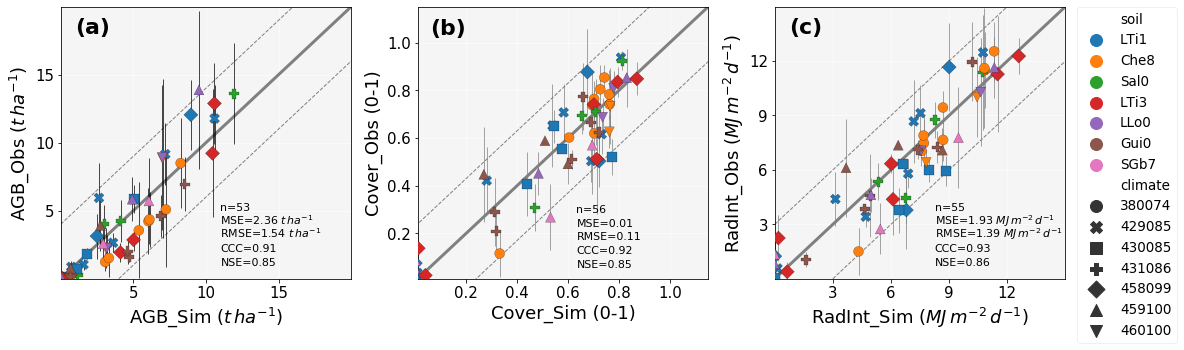

In [24]:
kwargs  =   {'edgecolor':"k"}
fig = plt.figure(figsize=(18,5))

ax=plt.subplot(1, 3, 1)
xmax=19.99
ymax=19.99
plt.plot([0,xmax],[0,ymax],"-",color="grey", linewidth=3,zorder=1)
plt.plot([0,xmax],[4,ymax+4],"--",color="grey", linewidth=1,zorder=1)
plt.plot([4,xmax+4],[0,ymax],"--",color="grey", linewidth=1,zorder=1)
ax.errorbar(agb['AGB_Pre'], agb['AGB_Obs'], yerr = agb['AGBError'], fmt ='o',marker='',zorder=2,color='k',linewidth=0.7)
sns.scatterplot(x="AGB_Pre", y="AGB_Obs",hue='soil',style='climate', alpha=1,data=agb,linewidth=0.2,**kwargs,s=100,zorder=3)

# Formatting graph and background
plt.legend(prop=dict(size=13.5),bbox_to_anchor=(3.5, 1), loc=2, borderaxespad=0., ncol=1,framealpha=0.3,markerscale=2)
plt.ylabel('AGB_Obs ($t\,ha^{-1}$)', fontsize =18)
plt.xlabel('AGB_Sim ($t\,ha^{-1}$)', fontsize =18)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
#ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(agb.AGB_Obs.values)
y_o= Obs.tolist()
Pre = pd.Series(agb.AGB_Pre.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values
plt.text(xmax*0.05, ymax*0.9,'(a)',fontsize=22,color='k',weight='bold')
plt.text(xmax*0.55, ymax*0.25,'n='+N,fontsize=11,color='k')
plt.text(xmax*0.55, ymax*0.2,'MSE='+MSE+' $t\,ha^{-1}$',fontsize=11,color='k')
plt.text(xmax*0.55, ymax*0.15,'RMSE='+RMSE+' $t\,ha^{-1}$',fontsize=11,color='k')
plt.text(xmax*0.55, ymax*0.1,'CCC='+CCC,fontsize=11,color='k')
plt.text(xmax*0.55, ymax*0.05,'NSE='+NSE,fontsize=11,color='k')

####################################################################
ax=plt.subplot(1, 3, 2) 
xmax=1.15
ymax=1.15
plt.plot([0,xmax],[0,ymax],"-",color="grey", linewidth=3,zorder=1)
plt.plot([0,xmax],[0.23,ymax+0.23],"--",color="grey", linewidth=1,zorder=1)
plt.plot([0.23,xmax+0.23],[0,ymax],"--",color="grey", linewidth=1,zorder=1)
ax.errorbar(agb['Cover_Pre'], agb['Cover_Obs'], yerr = agb['CoverError'], fmt ='o',marker='',zorder=2,color='grey',linewidth=0.7)
sns.scatterplot(x="Cover_Pre", y="Cover_Obs",hue='soil',style='climate', alpha=1,data=cov,linewidth=0.2,**kwargs,s=100,zorder=3)

# Formatting graph and background
plt.legend(prop=dict(size=10),bbox_to_anchor=(2.05, 0.99), loc=2, borderaxespad=0., ncol=1,framealpha=0.3)
plt.ylabel('Cover_Obs (0-1)', fontsize =18)
plt.xlabel('Cover_Sim (0-1)', fontsize =18)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(cov.Cover_Obs.values)
y_o= Obs.tolist()
Pre = pd.Series(cov.Cover_Pre.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values
plt.text(xmax*0.05, ymax*0.9,'(b)',fontsize=22,color='k',weight='bold')
plt.text(xmax*0.55, ymax*0.25,'n='+N,fontsize=11,color='k')
plt.text(xmax*0.55, ymax*0.2,'MSE='+MSE+'',fontsize=11,color='k')
plt.text(xmax*0.55, ymax*0.15,'RMSE='+RMSE+'',fontsize=11,color='k')
plt.text(xmax*0.55, ymax*0.1,'CCC='+CCC,fontsize=11,color='k')
plt.text(xmax*0.55, ymax*0.05,'NSE='+NSE,fontsize=11,color='k')

####################################################################
ax=plt.subplot(1, 3, 3)
xmax=14.99
ymax=14.99
plt.plot([0,xmax],[0,ymax],"-",color="grey", linewidth=3,zorder=1)
plt.plot([0,xmax],[3,ymax+3],"--",color="grey", linewidth=1,zorder=1)
plt.plot([3,xmax+3],[0,ymax],"--",color="grey", linewidth=1,zorder=1)
ax.errorbar(agb['RadInt_Pre'], agb['RadInt_Obs'], yerr = agb['RadIntError'], fmt ='o',marker='',zorder=2,color='grey',linewidth=0.7)
sns.scatterplot(x="RadInt_Pre", y="RadInt_Obs",hue='soil',style='climate', alpha=1,data=rad,linewidth=0.2,**kwargs,s=100,zorder=3)


# Formatting graph and background
plt.legend(prop=dict(size=10),bbox_to_anchor=(2.05, 0.99), loc=2, borderaxespad=0., ncol=1,framealpha=0.3)
plt.ylabel('RadInt_Obs ($MJ\,m^{-2}\,d^{-1}$)', fontsize =18)
plt.xlabel('RadInt_Sim ($MJ\,m^{-2}\,d^{-1}$)', fontsize =18)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
ax.yaxis.set_major_locator(ticker.MultipleLocator(3))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(rad.RadInt_Obs.values)
y_o= Obs.tolist()
Pre = pd.Series(rad.RadInt_Pre.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values
plt.text(xmax*0.05, ymax*0.9,'(c)',fontsize=22,color='k',weight='bold')
plt.text(xmax*0.55, ymax*0.25,'n='+N,fontsize=11,color='k')
plt.text(xmax*0.55, ymax*0.2,'MSE='+MSE+' $MJ\,m^{-2}\,d^{-1}$',fontsize=11,color='k')
plt.text(xmax*0.55, ymax*0.15,'RMSE='+RMSE+' $MJ\,m^{-2}\,d^{-1}$',fontsize=11,color='k')
plt.text(xmax*0.55, ymax*0.1,'CCC='+CCC,fontsize=11,color='k')
plt.text(xmax*0.55, ymax*0.05,'NSE='+NSE,fontsize=11,color='k')

####################################################################
plt.subplots_adjust(wspace=0.23, hspace=0.25)

#plt.savefig(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\paper\Figures\obsvspre.png', dpi=300,bbox_inches='tight')

In [46]:
df_final

,date,AGB_Pre,Cover_Pre,RadInt_Pre,Das,RUE_Pre,potentialET,SowingDate,RowSpacing,SowDensity,...,prevcrop,AGB_Obs,Cover_Obs,RadInt_Obs,AGGR_Obs,AGBError,CoverError,RadIntError,AGGRError,tmean
0,2019-11-26 12:00:00,0.013800,0.000000,0.000000,0,0.000000,6.929197,2019-11-26 12:00:00,525.0,13.80,...,O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.385000
1,2019-11-27 12:00:00,0.013800,0.000000,0.000000,1,0.000000,7.021189,2019-11-26 12:00:00,525.0,13.80,...,O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.725000
2,2019-11-28 12:00:00,0.013800,0.000000,0.000000,2,0.000000,5.779328,2019-11-26 12:00:00,525.0,13.80,...,O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.645000
3,2019-11-29 12:00:00,0.013800,0.000000,0.000000,3,0.000000,7.599846,2019-11-26 12:00:00,525.0,13.80,...,O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.325000
4,2019-11-30 12:00:00,0.013800,0.000000,0.000000,4,0.000000,6.927473,2019-11-26 12:00:00,525.0,13.80,...,O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.889999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2414,2019-03-05 12:00:00,9.293690,0.503983,5.755486,134,0.881581,5.062902,2018-10-22 12:00:00,210.0,53.55,...,O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.500000
2415,2019-03-06 12:00:00,9.375975,0.495455,4.587914,135,0.855242,4.320950,2018-10-22 12:00:00,210.0,53.55,...,O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.105000
2416,2019-03-07 12:00:00,9.439959,0.488259,3.686357,136,0.836864,3.583823,2018-10-22 12:00:00,210.0,53.55,...,O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.070000
2417,2019-03-08 12:00:00,9.514945,0.483503,4.960738,137,0.748437,4.112856,2018-10-22 12:00:00,210.0,53.55,...,O,13.878102,0.451111,4.628403,7.220309,5.812761,0.090882,0.932445,1.454614,15.185000


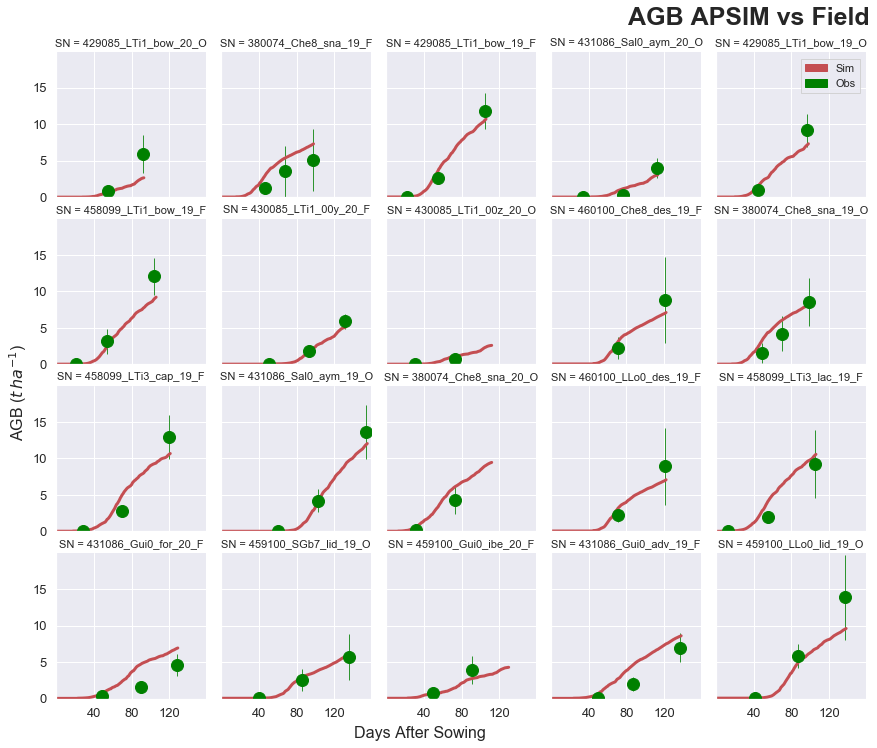

In [26]:
sns.set(font_scale=1)
g = sns.FacetGrid(df_final, col="SN", col_wrap=5, height=2.5, ylim=(0, 15))

g.map(plt.plot, "Das", "AGB_Pre", linestyle="-",linewidth=3,color='r')
ax = g.map(plt.errorbar, "Das", "AGB_Obs", "AGBError", fmt ='o',marker='',zorder=1,color='green',linewidth=0.8)
g.map(plt.plot, "Das", "AGB_Obs", linestyle="",linewidth=3,color='green',marker='o',markersize=12)

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='r', label='Sim')
blue_patch = mpatches.Patch(color='green', label='Obs')
plt.legend(handles=[red_patch, blue_patch], bbox_to_anchor=(1, 4.44), fancybox=False, shadow=False)

# Iterate thorugh each axis
for ax in g.axes.flat:
    ax.set_title(ax.get_title(),fontsize=11)
    ax.set_ylabel('', fontsize='medium')
    ax.set_xlabel('', fontsize='medium')
    ax.yaxis.set_tick_params(labelsize=13)
    ax.xaxis.set_tick_params(labelsize=13)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(40))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.set_xlim([0.01,159])
    ax.set_ylim([0,19.9])

g.fig.text(0.01, 0.43,'AGB ($t\,ha^{-1}$)', fontsize=16, rotation=90)
g.fig.text(0.395, 0.01,'Days After Sowing', fontsize=16)
g.fig.text(0.7, 1,'AGB APSIM vs Field', fontsize=25, fontweight="bold")

g.fig.subplots_adjust(wspace=0.1, hspace=.15)

#plt.savefig(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\Python\s2.png', dpi=300,bbox_inches='tight')

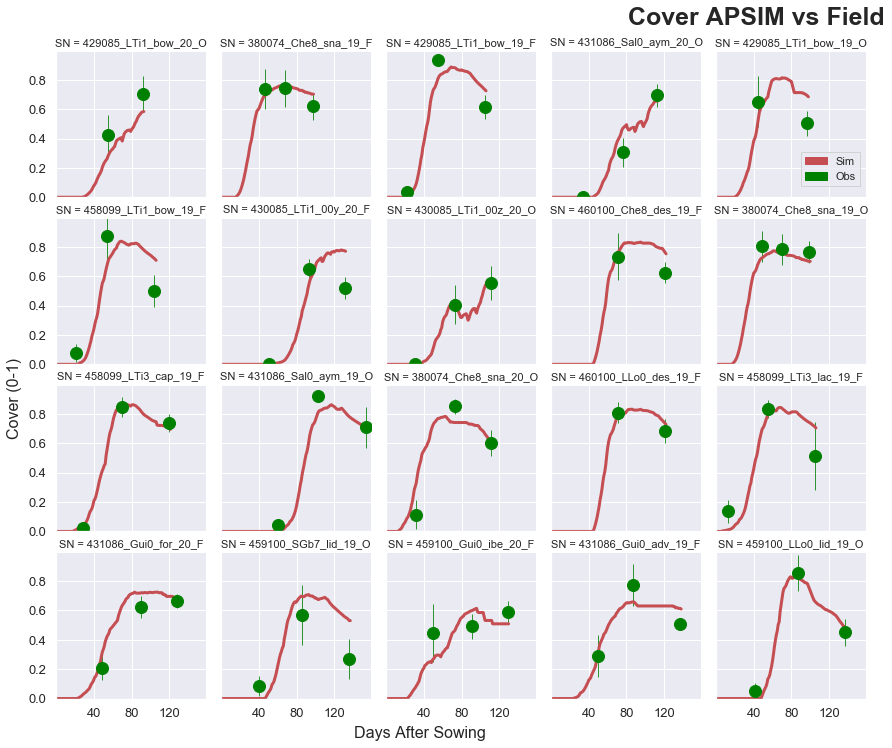

In [27]:
sns.set(font_scale=1)
g = sns.FacetGrid(df_final, col="SN", col_wrap=5, height=2.5, ylim=(0, 15))

g.map(plt.plot, "Das", "Cover_Pre", linestyle="-",linewidth=3,color='r')
g.map(plt.errorbar, "Das", "Cover_Obs", "CoverError", fmt ='o',marker='',zorder=1,color='green',linewidth=0.8)
g.map(plt.plot, "Das", "Cover_Obs", linestyle="",linewidth=3,color='green',marker='o',markersize=12)

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='r', label='Sim')
blue_patch = mpatches.Patch(color='green', label='Obs')
plt.legend(handles=[red_patch, blue_patch], bbox_to_anchor=(1, 3.8), fancybox=False, shadow=False)

# Iterate thorugh each axis
for ax in g.axes.flat:
    ax.set_title(ax.get_title(),fontsize=11)
    ax.set_ylabel('', fontsize='medium')
    ax.set_xlabel('', fontsize='medium')
    ax.yaxis.set_tick_params(labelsize=13)
    ax.xaxis.set_tick_params(labelsize=13)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(40))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.set_xlim([0.01,159])
    ax.set_ylim([0,0.99])

g.fig.text(0.01, 0.43,'Cover (0-1)', fontsize=16, rotation=90)
g.fig.text(0.395, 0.01,'Days After Sowing', fontsize=16)
g.fig.text(0.7, 1,'Cover APSIM vs Field', fontsize=25, fontweight="bold")

g.fig.subplots_adjust(wspace=0.1, hspace=.15)

#plt.savefig(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\Python\s2.png', dpi=300,bbox_inches='tight')

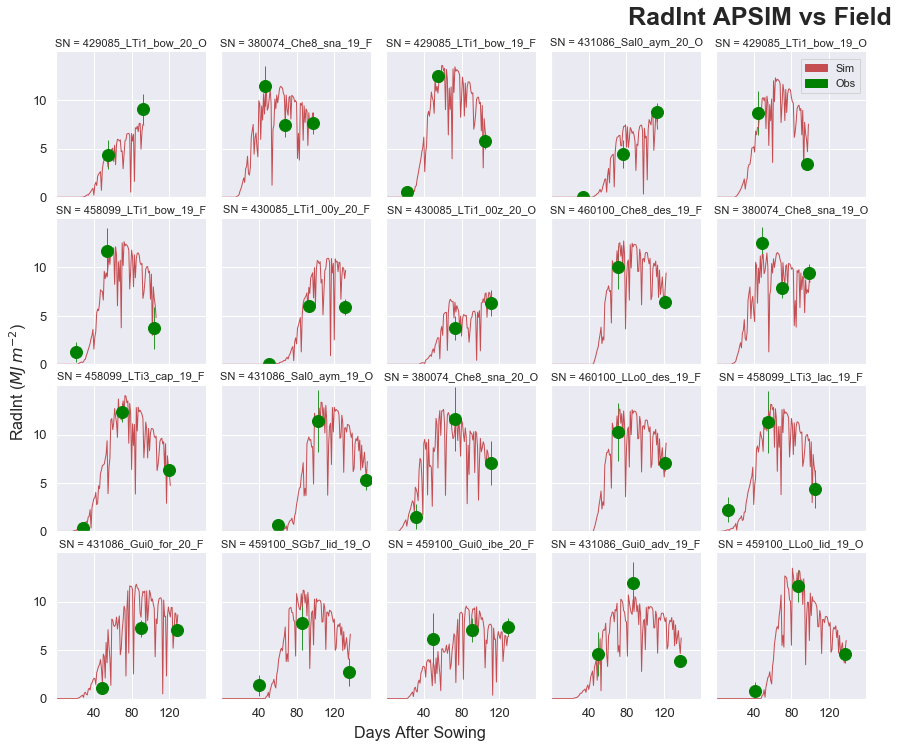

In [28]:
sns.set(font_scale=1)
g = sns.FacetGrid(df_final, col="SN", col_wrap=5, height=2.5, ylim=(0, 15))

g.map(plt.plot, "Das", "RadInt_Pre", linestyle="-",linewidth=1,color='r')
ax = g.map(plt.errorbar, "Das", "RadInt_Obs", "RadIntError", fmt ='o',marker='',zorder=1,color='green',linewidth=0.8)
g.map(plt.plot, "Das", "RadInt_Obs", linestyle="",linewidth=3,color='green',marker='o',markersize=12)

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='r', label='Sim')
blue_patch = mpatches.Patch(color='green', label='Obs')
plt.legend(handles=[red_patch, blue_patch], bbox_to_anchor=(1, 4.44), fancybox=False, shadow=False)

# Iterate thorugh each axis
for ax in g.axes.flat:
    ax.set_title(ax.get_title(),fontsize=11)
    ax.set_ylabel('', fontsize='medium')
    ax.set_xlabel('', fontsize='medium')
    ax.yaxis.set_tick_params(labelsize=13)
    ax.xaxis.set_tick_params(labelsize=13)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(40))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.set_xlim([0.01,159])
    ax.set_ylim([0,14.99])

g.fig.text(0.01, 0.43,'RadInt ($MJ\,m^{-2}$)', fontsize=16, rotation=90)
g.fig.text(0.395, 0.01,'Days After Sowing', fontsize=16)
g.fig.text(0.7, 1,'RadInt APSIM vs Field', fontsize=25, fontweight="bold")

g.fig.subplots_adjust(wspace=0.1, hspace=.15)

#plt.savefig(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\Python\s2.png', dpi=300,bbox_inches='tight')

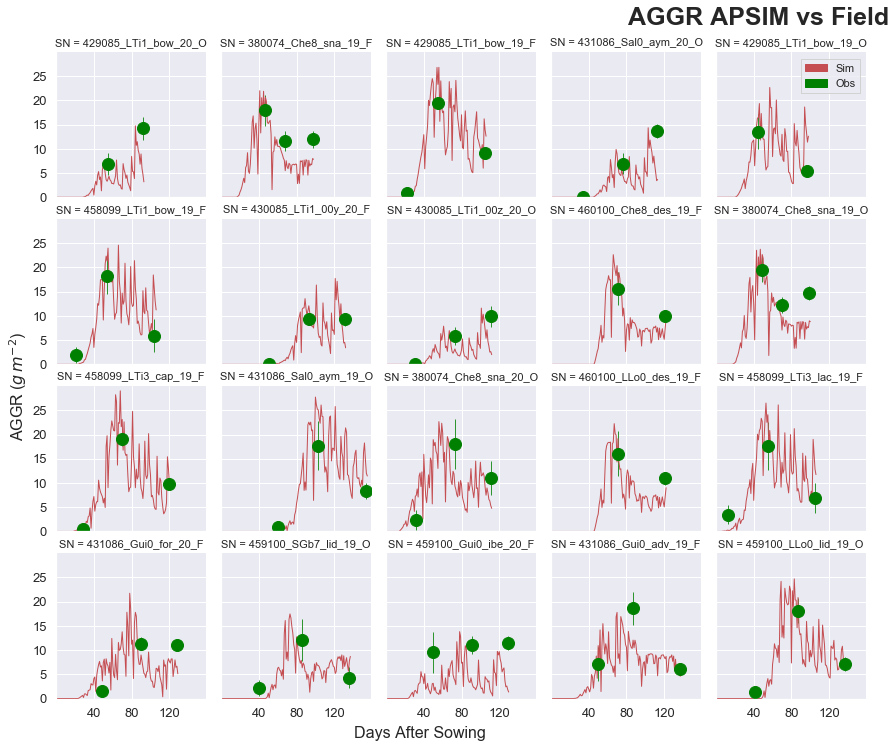

In [29]:
sns.set(font_scale=1)
g = sns.FacetGrid(df_final, col="SN", col_wrap=5, height=2.5, ylim=(0, 15))

g.map(plt.plot, "Das", "AGGR_Pre", linestyle="-",linewidth=1,color='r')
ax = g.map(plt.errorbar, "Das", "AGGR_Obs", "AGGRError", fmt ='o',marker='',zorder=1,color='green',linewidth=0.8)
g.map(plt.plot, "Das", "AGGR_Obs", linestyle="",linewidth=3,color='green',marker='o',markersize=12)

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='r', label='Sim')
blue_patch = mpatches.Patch(color='green', label='Obs')
plt.legend(handles=[red_patch, blue_patch], bbox_to_anchor=(1, 4.44), fancybox=False, shadow=False)

# Iterate thorugh each axis
for ax in g.axes.flat:
    ax.set_title(ax.get_title(),fontsize=11)
    ax.set_ylabel('', fontsize='medium')
    ax.set_xlabel('', fontsize='medium')
    ax.yaxis.set_tick_params(labelsize=13)
    ax.xaxis.set_tick_params(labelsize=13)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(40))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.set_xlim([0.01,159])
    ax.set_ylim([0,29.99])

g.fig.text(0.01, 0.43,'AGGR ($g\,m^{-2}$)', fontsize=16, rotation=90)
g.fig.text(0.395, 0.01,'Days After Sowing', fontsize=16)
g.fig.text(0.7, 1,'AGGR APSIM vs Field', fontsize=25, fontweight="bold")

g.fig.subplots_adjust(wspace=0.1, hspace=.15)

#plt.savefig(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\Python\s2.png', dpi=300,bbox_inches='tight')

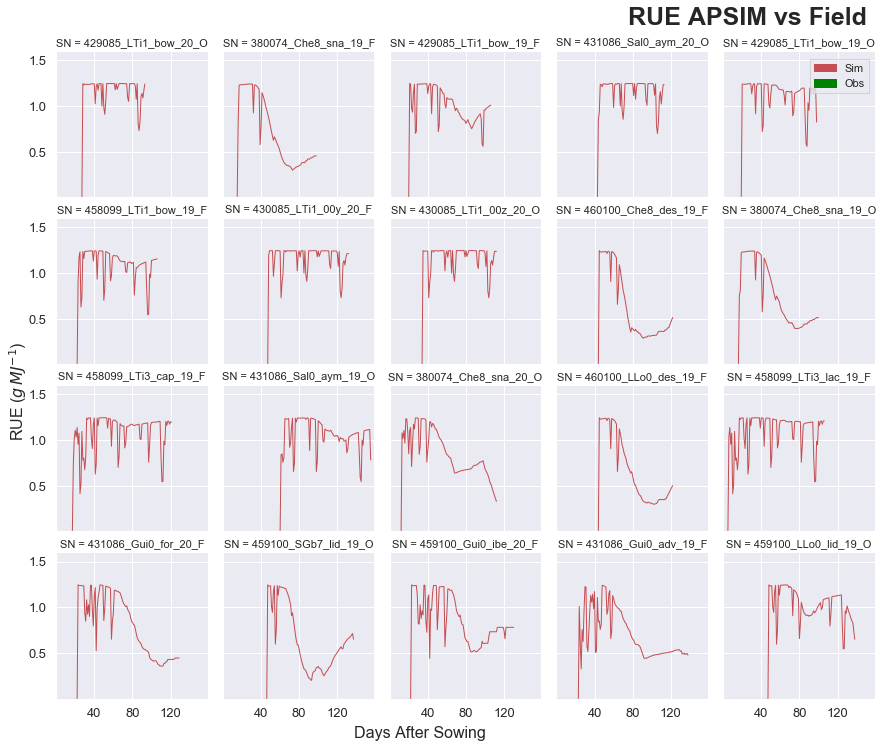

In [33]:
sns.set(font_scale=1)
g = sns.FacetGrid(df_final, col="SN", col_wrap=5, height=2.5, ylim=(0, 15))

g.map(plt.plot, "Das", "RUE_Pre", linestyle="-",linewidth=1,color='r')
#ax = g.map(plt.errorbar, "Das", "RUE_Obs", "RUEError", fmt ='o',marker='',zorder=1,color='green',linewidth=0.8)
#g.map(plt.plot, "Das", "RUE_Obs", linestyle="",linewidth=3,color='green',marker='o',markersize=12)

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='r', label='Sim')
blue_patch = mpatches.Patch(color='green', label='Obs')
plt.legend(handles=[red_patch, blue_patch], bbox_to_anchor=(1, 4.44), fancybox=False, shadow=False)

# Iterate thorugh each axis
for ax in g.axes.flat:
    ax.set_title(ax.get_title(),fontsize=11)
    ax.set_ylabel('', fontsize='medium')
    ax.set_xlabel('', fontsize='medium')
    ax.yaxis.set_tick_params(labelsize=13)
    ax.xaxis.set_tick_params(labelsize=13)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(40))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.set_xlim([0.01,159])
    ax.set_ylim([0.01,1.59])

g.fig.text(0.01, 0.43,'RUE ($g\,MJ^{-1}$)', fontsize=16, rotation=90)
g.fig.text(0.395, 0.01,'Days After Sowing', fontsize=16)
g.fig.text(0.7, 1,'RUE APSIM vs Field', fontsize=25, fontweight="bold")

g.fig.subplots_adjust(wspace=0.1, hspace=.15)

#plt.savefig(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\Python\s2.png', dpi=300,bbox_inches='tight')

In [44]:
#Calculate statistics
summ_min = df_final.groupby(['climate', 'soil', 'cultivar', 'harvest', 'prevcrop'], as_index=False)['tmin'].mean().round(decimals=1)
summ_max = df_final.groupby(['climate', 'soil', 'cultivar', 'harvest', 'prevcrop'], as_index=False)['tmax'].mean().round(decimals=1)
summ_mean = df_final.groupby(['climate', 'soil', 'cultivar', 'harvest', 'prevcrop'], as_index=False)['tmean'].mean().round(decimals=1)

summ_rain = df_final.groupby(['climate', 'soil', 'cultivar', 'harvest', 'prevcrop'], as_index=False)['rain'].sum().round(decimals=1)
summ_rad = df_final.groupby(['climate', 'soil', 'cultivar', 'harvest', 'prevcrop'], as_index=False)['radn'].sum().round(decimals=1)

summ_ET = df_final.groupby(['climate', 'soil', 'cultivar', 'harvest', 'prevcrop'], as_index=False)['potentialET'].sum().round(decimals=1)
summ_PAWC = df_final.groupby(['climate', 'soil', 'cultivar', 'harvest', 'prevcrop','SowingDate','RowSpacing',
                              'SowDensity'], as_index=False)['PAWC'].mean().round(decimals=1)

st0 = pd.merge(summ_min, summ_max, on=['climate', 'soil', 'cultivar', 'harvest', 'prevcrop'])
st0.rename(columns={'tmin_x':'tmean_min','tmax_y':'tmean_max'}, inplace=True)

st00 = pd.merge(summ_mean, summ_rain, on=['climate', 'soil', 'cultivar', 'harvest', 'prevcrop'])
st00.rename(columns={'tmean_x':'tmean_mean','rain_y':'rain'}, inplace=True)

st000 = pd.merge(summ_rad, summ_ET, on=['climate', 'soil', 'cultivar', 'harvest', 'prevcrop'])
st000.rename(columns={'rad_x':'radn','ET_y':'ET'}, inplace=True)

data_frames = [st0, st00, st000, summ_PAWC]
st = reduce(lambda  left,right: pd.merge(left,right,on=['climate', 'soil', 'cultivar', 'harvest', 'prevcrop'], how='outer'), data_frames)
st
#st.to_csv(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\Python\stat.csv', index=None, mode='a')

,climate,soil,cultivar,harvest,prevcrop,tmin,tmax,tmean,rain,radn,potentialET,SowingDate,RowSpacing,SowDensity,PAWC
0,380074,Che8,sna,19,F,13.5,28.4,21.0,437.0,2511.6,574.7,2018-12-02 12:00:00,350.0,28.3,304.6
1,380074,Che8,sna,19,O,13.5,28.3,20.9,459.0,2551.4,582.8,2018-11-30 12:00:00,350.0,28.8,304.6
2,380074,Che8,sna,20,O,13.4,29.9,21.6,317.2,2875.6,670.2,2019-11-11 12:00:00,350.0,28.7,304.6
3,429085,LTi1,bow,19,F,12.8,27.7,20.3,441.2,3101.8,701.2,2018-11-20 12:00:00,350.0,39.6,169.3
4,429085,LTi1,bow,19,O,13.4,28.6,21.0,314.6,2605.1,597.9,2018-11-30 12:00:00,350.0,28.2,169.3
5,429085,LTi1,bow,20,O,13.4,29.5,21.4,246.0,2483.5,588.6,2019-11-26 12:00:00,525.0,13.8,169.3
6,430085,LTi1,00y,20,F,12.5,28.5,20.5,336.9,3395.9,788.7,2019-10-20 12:00:00,520.0,25.9,169.3
7,430085,LTi1,00z,20,O,13.2,29.4,21.3,288.2,2955.7,698.7,2019-11-09 12:00:00,520.0,23.1,169.3
8,431086,Gui0,adv,19,F,12.1,26.8,19.4,530.1,3393.5,760.1,2018-10-21 12:00:00,420.0,23.8,117.5
9,431086,Gui0,for,20,F,12.2,28.5,20.4,336.3,3242.9,740.8,2019-10-23 12:00:00,420.0,23.3,117.5
